# Audio Classification with CRNN — end‑to‑end walkthrough

## Setup

We start by bringing in the external libraries and gathering all project‑level constants—paths, sample rate, batch size, seed, and the number of training epochs—so they live in one easy‑to‑tweak place.

### Imports & hyper‑parameters

In [1]:
import random, shutil
from pathlib import Path
import numpy as np
import torch, torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import display, Markdown

%matplotlib inline
sns.set_style("whitegrid")

# Constants
SR          = 16_000
N_MELS      = 128
N_FFT       = 1024
HOP_LENGTH  = 256
TIME_MASK   = 30
FREQ_MASK   = 15
BATCH_SIZE  = 32
EPOCHS      = 20
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Data utilities

### Cleaning helper — `prune_bad_wavs`

Any recording that is corrupt or shorter than the minimum duration is moved into a separate *quarantine* folder. This keeps data loading reliable without silently dropping files.

In [2]:
def prune_bad_wavs(root, quarantine="bad_wavs"):
    root, bad = Path(root), 0
    qt = root.parent / quarantine
    qt.mkdir(exist_ok=True)
    for wav in root.rglob("*.wav"):
        try:
            info = torchaudio.info(str(wav))
            if info.num_frames == 0:
                raise ValueError("0 frames")
        except Exception:
            bad += 1
            shutil.move(str(wav), qt / wav.name)
    if bad:
        print(f"Moved {bad} bad wavs → {qt}")


for split in ("cleaned_dataset/train", "cleaned_dataset/test"):
    prune_bad_wavs(split)

### Utility — `class_counts`

A quick helper that walks the dataset tree and prints how many examples belong to each label. It’s an easy way to spot class imbalance before training.

In [3]:
def class_counts(root):
    return {d: len(list(Path(root, d).glob("*.wav"))) for d in ("others", "questions")}


for split in ("cleaned_dataset/train", "cleaned_dataset/test"):
    print(split, ":", class_counts(split))

# Sanity check
tr_counts = class_counts("cleaned_dataset/train")
if 0 in tr_counts.values():
    raise RuntimeError("🚫 One of the train classes is empty – check dataset!")

cleaned_dataset/train : {'others': 5768, 'questions': 4504}
cleaned_dataset/test : {'others': 6042, 'questions': 1103}


## Dataset & DataLoaders

### Feature extraction & custom `Dataset`

Here we turn raw waveforms into log‑scale mel‑spectrograms, add light augmentation during training, and wrap everything in a PyTorch `Dataset`. A custom collate function takes care of pad‑to‑max‑length so variable‑length clips can share a batch.

In [4]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    f_min=0,
    f_max=SR // 2,
)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)


class AudioDS(Dataset):
    def __init__(self, root, augment=False):
        self.files, self.labels = [], []
        self.augment = augment
        for lbl, cls in enumerate(("others", "questions")):
            for f in Path(root, cls).glob("*.wav"):
                self.files.append(f)
                self.labels.append(lbl)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        wav, sr = torchaudio.load(self.files[i])
        if sr != SR:  # resample if needed
            wav = torchaudio.functional.resample(wav, sr, SR)
        wav = wav.mean(0, keepdim=True)  # mono
        wav = (wav - wav.mean()) / (wav.std() + 1e-9)

        mel = to_db(mel_transform(wav)).squeeze(0)  # (mel, time)
        mel = (mel - mel.mean()) / (mel.std() + 1e-9)

        if self.augment:
            mel = torchaudio.transforms.TimeMasking(TIME_MASK)(mel)
            mel = torchaudio.transforms.FrequencyMasking(FREQ_MASK)(mel)
        return mel, self.labels[i]


def pad_collate(batch):
    specs, labs = zip(*batch)
    Tmax = max(s.shape[1] for s in specs)
    padded = torch.zeros(len(specs), N_MELS, Tmax)
    for i, s in enumerate(specs):
        padded[i, : s.shape[0], : s.shape[1]] = s
    return padded, torch.tensor(labs)

### DataLoaders

This block draws stratified train/validation/test splits and feeds them into PyTorch `DataLoader`s for shuffling and efficient mini‑batching.

In [5]:
train_full = AudioDS("cleaned_dataset/train", augment=True)
val_size = int(0.1 * len(train_full))
train_ds, val_ds = torch.utils.data.random_split(
    train_full, [len(train_full) - val_size, val_size]
)

train_dl = DataLoader(train_ds, BATCH_SIZE, True, collate_fn=pad_collate)
val_dl = DataLoader(val_ds, BATCH_SIZE, False, collate_fn=pad_collate)
test_dl = DataLoader(
    AudioDS("cleaned_dataset/test"), BATCH_SIZE, False, collate_fn=pad_collate
)

## Model

### Architecture — Convolutional Recurrent Neural Network

The core model starts with a small stack of 2‑D convolutions that learn local time–frequency patterns, then hands the feature maps to a bidirectional LSTM that captures longer‑range temporal context before a fully connected classifier produces per‑class logits.

In [6]:
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # infer feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, 100)
            c, f, t = self.cnn(dummy).shape[1:]
        self.lstm = nn.LSTM(64 * f, 128, 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 2)

    def forward(self, x):  # x (B, mel, T)
        x = self.cnn(x.unsqueeze(1))  # (B, 64, mel/4, T/4)
        b, c, f, t = x.shape
        x = x.reshape(b, c * f, t).permute(0, 2, 1)  # (B, T/4, features)
        x, _ = self.lstm(x)
        out = self.fc(x[:, -1])
        return out


model = CRNN().to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

2.645058 M parameters


### Training routine

We define cross‑entropy loss, set up an Adam optimiser with a 1 e‑3 learning rate, and run the main training loop while logging loss, accuracy and macro‑F1 for both splits to a `history` dict.

In [7]:
crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), 1e-3)

history = {
    "tr_loss": [],
    "tr_acc": [],
    "tr_f1": [],
    "vl_loss": [],
    "vl_acc": [],
    "vl_f1": [],
}


def run_epoch(dl, train=False):
    model.train() if train else model.eval()

    tot, correct = 0, 0
    losses, all_p, all_y = [], [], []

    for spec, y in dl:
        spec, y = spec.to(device), y.to(device)
        logits = model(spec)
        loss = crit(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        pred = logits.argmax(1)
        tot += y.size(0)
        correct += (pred == y).sum().item()
        all_p.extend(pred.cpu().tolist())
        all_y.extend(y.cpu().tolist())
        losses.append(loss.item() * y.size(0))

    acc = correct / tot
    f1 = f1_score(all_y, all_p)
    return np.sum(losses) / tot, acc, f1


for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(train_dl, train=True)
    vl_loss, vl_acc, vl_f1 = run_epoch(val_dl, train=False)

    history["tr_loss"].append(tr_loss)
    history["tr_acc"].append(tr_acc)
    history["tr_f1"].append(tr_f1)
    history["vl_loss"].append(vl_loss)
    history["vl_acc"].append(vl_acc)
    history["vl_f1"].append(vl_f1)

    print(
        f"Ep {ep:02d} | "
        f"train L {tr_loss:.3f} A {tr_acc:.3f} F1 {tr_f1:.3f}  ||  "
        f"val L {vl_loss:.3f} A {vl_acc:.3f} F1 {vl_f1:.3f}"
    )

Ep 01 | train L 0.659 A 0.601 F1 0.473  ||  val L 0.648 A 0.606 F1 0.602
Ep 02 | train L 0.632 A 0.631 F1 0.574  ||  val L 0.584 A 0.697 F1 0.684
Ep 03 | train L 0.540 A 0.737 F1 0.691  ||  val L 0.617 A 0.711 F1 0.600
Ep 04 | train L 0.508 A 0.757 F1 0.708  ||  val L 0.466 A 0.785 F1 0.761
Ep 05 | train L 0.455 A 0.787 F1 0.740  ||  val L 0.459 A 0.788 F1 0.761
Ep 06 | train L 0.436 A 0.799 F1 0.748  ||  val L 0.594 A 0.675 F1 0.472
Ep 07 | train L 0.430 A 0.799 F1 0.750  ||  val L 0.403 A 0.811 F1 0.789
Ep 08 | train L 0.412 A 0.810 F1 0.764  ||  val L 0.406 A 0.802 F1 0.755
Ep 09 | train L 0.400 A 0.818 F1 0.770  ||  val L 0.385 A 0.816 F1 0.779
Ep 10 | train L 0.386 A 0.823 F1 0.778  ||  val L 0.406 A 0.807 F1 0.753
Ep 11 | train L 0.379 A 0.830 F1 0.787  ||  val L 0.379 A 0.825 F1 0.796
Ep 12 | train L 0.368 A 0.831 F1 0.789  ||  val L 0.377 A 0.820 F1 0.789
Ep 13 | train L 0.355 A 0.834 F1 0.795  ||  val L 0.365 A 0.826 F1 0.794
Ep 14 | train L 0.349 A 0.839 F1 0.801  ||  val L 0

## Evaluation & Visualisation

### Final evaluation

After training, we run one forward pass over the held‑out test split (no gradient tracking) and print the aggregated metrics so we have an unbiased estimate of generalisation performance.

In [8]:
test_loss, test_acc, test_f1 = run_epoch(test_dl)
print(f"\nTest  |  loss {test_loss:.3f}   acc {test_acc:.3f}   F1 {test_f1:.3f}")


Test  |  loss 0.339   acc 0.856   F1 0.619


### Visualising individual predictions — `show_preds`

A small convenience that randomly samples spectrograms, overlays the predicted and true labels, and helps us eyeball typical successes and mistakes.

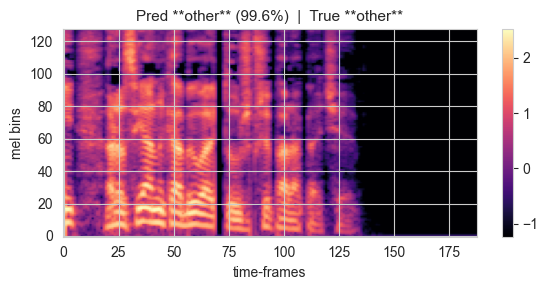

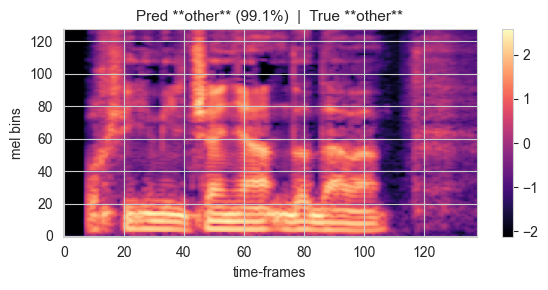

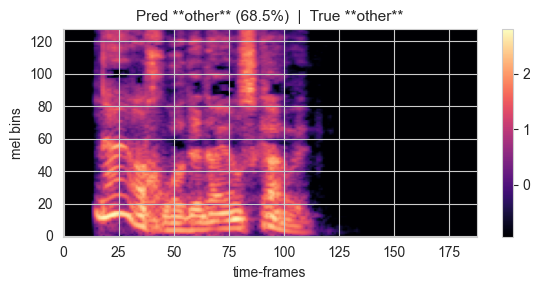

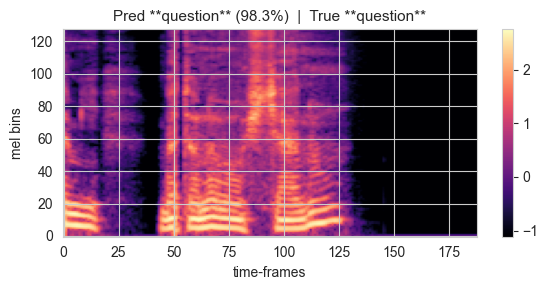

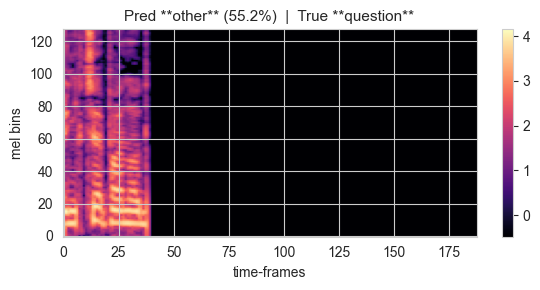

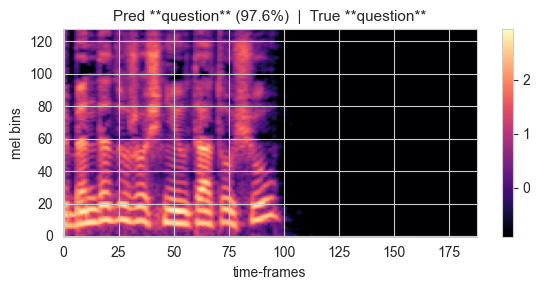

Displayed **6** samples (balanced selection).

In [9]:
CLASSES = ["other", "question"]


def show_preds(n_total: int = 6, balanced: bool = True):
    model.eval()

    idx_by_class = {0: [], 1: []}
    for idx, lbl in enumerate(test_dl.dataset.labels):
        idx_by_class[lbl].append(idx)

    shown = set()
    for c in range(2):
        k = (n_total + 1) // 2 if balanced else n_total
        k = min(k, len(idx_by_class[c]))
        picks = random.sample(idx_by_class[c], k)
        for idx in picks:
            if idx in shown:
                continue
            shown.add(idx)

            spec, label = test_dl.dataset[idx]
            with torch.no_grad():
                logits = model(spec.unsqueeze(0).to(device))
                probs = logits.softmax(1).cpu().numpy()[0]
                pred = probs.argmax()
                conf = probs[pred]

            plt.figure(figsize=(6, 3))
            plt.imshow(spec.numpy(), aspect="auto", origin="lower", cmap="magma")
            title = (
                f"Pred **{CLASSES[pred]}** ({conf*100:.1f}%)  |  "
                f"True **{CLASSES[label]}**"
            )
            plt.title(title, fontsize=11)
            plt.xlabel("time-frames")
            plt.ylabel("mel bins")
            plt.colorbar()
            plt.tight_layout()
            plt.show()

    display(
        Markdown(
            f"Displayed **{len(shown)}** samples "
            f"({'balanced' if balanced else 'random'} selection)."
        )
    )

show_preds(n_total=6, balanced=True)

### Training curves & confusion matrix

Finally we turn the `history` dict into a Pandas DataFrame to plot training curves, and we compute a confusion matrix plus a full classification report for a more detailed look at where the model excels or struggles.

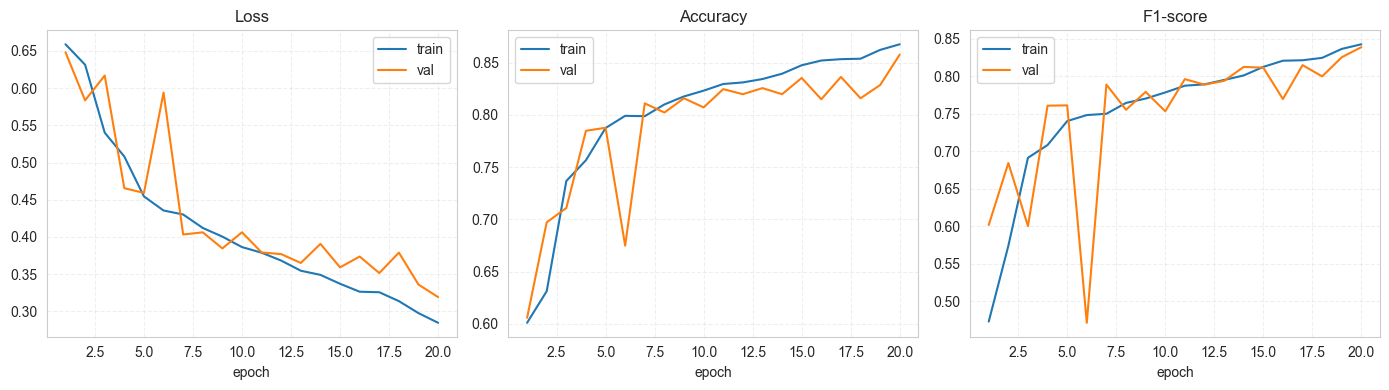

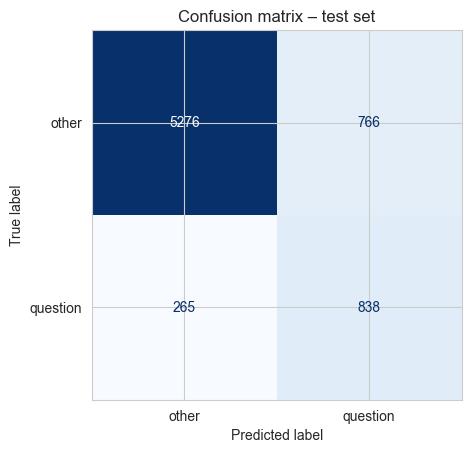


               precision    recall  f1-score   support

       other       0.95      0.87      0.91      6042
    question       0.52      0.76      0.62      1103

    accuracy                           0.86      7145
   macro avg       0.74      0.82      0.77      7145
weighted avg       0.89      0.86      0.87      7145



In [10]:
import pandas as pd

df_hist = pd.DataFrame(history)
df_hist["epoch"] = range(1, len(df_hist) + 1)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.lineplot(data=df_hist, x="epoch", y="tr_loss", label="train", ax=axs[0])
sns.lineplot(data=df_hist, x="epoch", y="vl_loss", label="val", ax=axs[0])
axs[0].set_title("Loss")
axs[0].set_ylabel("")
axs[0].legend()

# Accuracy
sns.lineplot(data=df_hist, x="epoch", y="tr_acc", label="train", ax=axs[1])
sns.lineplot(data=df_hist, x="epoch", y="vl_acc", label="val", ax=axs[1])
axs[1].set_title("Accuracy")
axs[1].set_ylabel("")

# F1-score
sns.lineplot(data=df_hist, x="epoch", y="tr_f1", label="train", ax=axs[2])
sns.lineplot(data=df_hist, x="epoch", y="vl_f1", label="val", ax=axs[2])
axs[2].set_title("F1-score")
axs[2].set_ylabel("")

for ax in axs:
    ax.set_xlabel("epoch")
    ax.grid(True, ls="--", alpha=0.3)

plt.tight_layout()
plt.show()


model.eval()
all_p, all_y = [], []
with torch.no_grad():
    for spec, y in test_dl:
        logits = model(spec.to(device))
        all_p.extend(logits.argmax(1).cpu())
        all_y.extend(y)

cm = confusion_matrix(all_y, all_p)
disp = ConfusionMatrixDisplay(cm, display_labels=["other", "question"])
disp.plot(cmap="Blues", colorbar=False)
plt.title("Confusion matrix – test set")
plt.show()

print("\n", classification_report(all_y, all_p, target_names=["other", "question"]))